10000.0 131 0.40307692307692305 0.0002574759400760798
1000.0 134 0.4123076923076923 0.021492223173725244
100.0 260 0.8 0.7431706923227446
10.0 297 0.9138461538461539 7.995408933866858
1.0 320 0.9846153846153847 54.3233745312258
0.1 323 0.9938461538461538 271.8805138328722
0.01 324 0.9969230769230769 676.8827778789145
0.001 324 0.9969230769230769 683.7185219969531
0.0001 324 0.9969230769230769 684.3389843680258
1e-05 324 0.9969230769230769 684.4005149522335


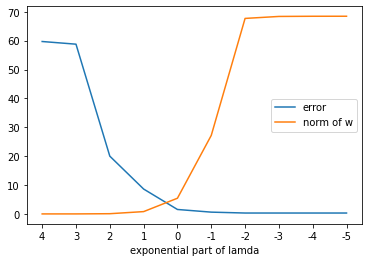

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# import auto diff
from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes
from autograd import grad
from autograd import numpy as np
import matplotlib.pyplot as plt
from autograd.misc.flatten import flatten_func
import pandas as pd
import time

data = pd.read_csv("dataCollection.csv")

number = data['USAF'].values
latitude = data['Latitude'].values
longitude = data['Longitude'].values
etr = data['Avg hourly ETR in 2005 (Wh/m^2)'].values
length = number.size
train_length = 600
test_length = length - train_length
classes = np.empty(length,dtype=int)

#standard normalization
var_x = np.var(longitude)
var_y = np.var(latitude)
mean_x = np.mean(longitude)
mean_y = np.mean(latitude)
x_norm = (longitude - mean_x)/np.sqrt(var_x)
y_norm = (latitude - mean_y)/np.sqrt(var_y)
N = 2 #No. of features

#define classes labels
C = 3 # No. of classes
for i in range(length):
    if etr[i] < 320:
        classes[i]=0
    elif 320 <= etr[i] < 340:
        classes[i]=1
    else:
        classes[i]=2


#split shuffled data for training and testing
x_train = x_norm[:train_length]
y_train = y_norm[:train_length]
classes_train = classes[:train_length]
x_test = x_norm[train_length:]
y_test = y_norm[train_length:]
classes_test = classes[train_length:]


# define model, which compute C linear combinations, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

def softmax(x):
    # max = np.max(x,axis=0,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x) #subtracts each row with its max value
    sum = np.sum(e_x,axis=0,keepdims=True) #returns sum of each row and keeps same dims
    return np.log(sum)

# multiclass perceptron cost function

def multiclass_perceptron(w):
    # pre-compute predictions on all points
    all_evals = model(x,w)
    # compute max across data points
    a = softmax(all_evals)#,axis=0
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int),np.arange(np.size(y))]
    cost = np.sum(a-b)
    # add regularization parameter
    cost = cost + lam*np.linalg.norm(w[1:,:])**2
    # return average
    return cost/float(np.size(y))

# gradient descent function
def gradient_descent(g, step, max_its, w):
    # flatten g
    g_flat, unflatten_func, w_flat = flatten_func(g,w)
    # compute gradient
    gradient = grad(g_flat)
    # gradient descent loop
    weight_history = [w_flat] # weight history container
    cost_history = [g_flat(w_flat)] # cost history container
    for k in range(max_its):
        # eval gradient
        grad_eval = gradient(w_flat)
        grad_eval_norm = grad_eval / np.linalg.norm(grad_eval)
        # take grad descent step
        alpha = 5/(k+1)
        w_flat = w_flat - alpha*grad_eval_norm
        # record weight and cost
        weight_history.append(w_flat)
        cost_history.append(g_flat(w_flat))
    return weight_history, cost_history, unflatten_func


x = np.c_[x_train,y_train].T
y = classes_train.T.reshape(1,-1)
w = np.random.random((N+1,C)) #w0, w1, w2

iter = 1000

lam = 10**5 # reg param
w_norm = []
error = []
for n in range(10):
    lam = lam/10
    a, b, unflatten = gradient_descent(multiclass_perceptron,'d',iter,w)
    wp = unflatten(a[iter])

    #verify test dataset
    data_verify = np.c_[x_test,y_test].T
    verify_result = z=np.argmax(model(data_verify, wp),axis=0)
    true_number = 0
    for i in range(test_length):
        if verify_result[i] == classes_test[i]:
            true_number = true_number +1
    w_norm.append(np.linalg.norm(wp[1:,:],'fro')**2/10)
    print(lam, true_number, true_number/test_length,np.linalg.norm(wp[1:,:],'fro')**2)
    error.append(100*(1-true_number/test_length))

plt.xticks(np.arange(0,10),np.arange(4,-6,-1))
plt.xlabel('exponential part of lamda')

plt.plot(error, label='error')
plt.plot(w_norm, label='norm of w')
# ax=plt.gca()
# for i in ['top','right']:
#     ax.spines[i].set_visible(False)
plt.legend()
plt.show()


